In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# %cd /content/drive/My\ Drive/CS231N/project/Confounder-Aware-CNN-Visualization-master
%cd /Users/elissali/Documents/GitHub/cs231n-adni/new_code

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
import torch

import sys
import argparse
import os
import glob 

# visualize saliency
import matplotlib
import matplotlib.pyplot as plt

import data, model, interpretation, utils, vis_utils

(251, 64, 64, 64, 1) (251,)
torch.Size([32, 1])


In [3]:
% cd ~/Documents/GitHub/cs231n-adni/new_code

# train_data = np.load("train_aug.npy")
val_data = np.load("val_aug.npy")
test_data = np.load("test_aug.npy")
# train_label = np.load("train_label_aug.npy")
val_label = np.load("val_label_aug.npy")
test_label = np.load("test_label_aug.npy")

# train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))
val_data = np.reshape(val_data, (512, 1, 64, 64, 64))
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


# Gather data
We need a set of images, their corresponding labels, and the corresponding ages of the patient for each image. We use our unaugmented test set for this analysis.

Here's the code to isolate the ages of our test set.

In [4]:
% cd /Users/elissali/Documents/GitHub/cs231n-adni/new_code
import csv

# get ages of images corresponding to data in fold
def nb_get_ages(fold=4):
    reader = csv.DictReader(open("../metadata/ADNIMERGE.csv"))

    # create a dict of just name and date, so we don't have to loop through
    # entire csv later.
    items = {}
    for row in reader:
        ptid = row['PTID']
        #date = row['EXAMDATE']
        #key = ptid + "-" + date
        #items[key] = row['AGE']
        try:
            age = float(row['AGE'])
            items[ptid] = age
        except ValueError:
            print("cannot convert " + row['AGE'])
        
    #print(items)

    # load image names
    file_idx = np.genfromtxt('subjects_idx.txt', dtype='str')
    # load fold indices
    fold_idx = np.loadtxt('fold.txt')
    want_idx = (fold_idx == fold)
    ages = np.zeros(251) # empty list
    print("number of examples: ", len(want_idx))

    unmatched = 0
    idx = 0
    for i in range(len(want_idx)):
        if want_idx[i]:
            name_full = file_idx[i] # format: 002_S_0295-2006-04-18_08_20_30.0.nii.gz
            name_ptid = name_full[:10] # first 10 characters, ex 002_S_0295
            #name_date = name_full[11:21] # ex 2006-04-18
            #name_key = name_full[:21] # subject + date, since age changes over time
            name_key = name_ptid

            # look in dictionary to get age
            if name_key in items:
                ages[idx] = items[name_key]
                #print("ages[idx] = items[name_key]: " + str(idx) + " " + str(items[name_key]))
            else:
                unmatched += 1
                ages[idx] = -1
                print("no key for " + name_key)
            idx += 1

    print("number of unmatched examples: " + str(unmatched))
    print(ages)
    return ages

ages = nb_get_ages()
#np.save("ages", ages)

/Users/elissali/Documents/GitHub/cs231n-adni/new_code
cannot convert 
cannot convert 
cannot convert 
cannot convert 
number of examples:  1334
number of unmatched examples: 0
[70.8 70.8 70.8 82.2 82.2 82.2 82.2 88.6 88.6 88.6 88.6 84.9 70.7 70.7
 70.7 70.7 70.7 70.7 70.7 71.5 71.5 71.5 71.5 74.4 74.4 74.4 74.  74.
 74.5 74.5 74.5 74.5 73.4 64.9 64.9 64.9 64.9 76.6 76.6 76.6 75.8 75.8
 75.8 75.8 75.3 74.9 74.9 74.9 74.9 74.9 83.  83.  83.  83.  80.2 81.3
 81.3 81.3 81.3 81.3 86.3 78.5 78.5 78.5 74.5 74.5 74.5 74.5 72.2 72.2
 70.1 70.1 70.1 70.1 70.1 70.1 70.1 77.  77.  77.  77.  70.6 70.6 70.6
 70.6 70.6 70.6 77.2 77.2 77.2 75.3 75.3 75.3 75.3 70.5 70.5 70.5 70.5
 70.5 71.1 71.1 71.1 87.6 87.6 87.6 87.6 87.6 78.6 78.6 57.1 57.1 57.1
 57.1 78.3 78.3 78.3 78.3 78.3 77.6 77.6 78.3 78.3 78.3 78.3 78.3 62.
 62.  62.  62.  62.  77.1 77.1 77.1 76.9 76.9 76.9 77.3 77.3 71.4 71.4
 71.4 71.4 71.4 70.6 70.6 70.6 70.6 77.3 77.3 77.3 77.3 79.2 79.2 74.8
 74.8 77.4 62.  74.6 74.6 74.6 74.6 71.  78. 

Manually verify that above ages correspond to the test data properly. Below, we use each test data's filename in place of the actual image. We can see that the first 3 test data belong to patient 002_S_0816, and the next few belong to patient 002_S_0938. Correspondingly, the ages are 70.8 and 82.2, which is correct, according to the spreadsheet.

In [5]:
# We only get the ages for the first 251 examples from the test set (the real examples)
# so we also need to truncate the test data and test labels.
def get_dummy_test_data_unaugmented():
    # Load the data
    file_idx = np.genfromtxt('./subjects_idx.txt', dtype='str') 
    fold_idx = np.loadtxt('fold.txt')                   # to keep same-patient images together
    label = np.loadtxt('dx.txt')
    np.random.seed(seed=0)

    subject_num = file_idx.shape[0]
    print("data.py line 13: ", subject_num)

    data = []
    for img_idx in file_idx:
        data.append(img_idx)
    print(data)
    print(len(data))

    print("data.py: line 39: finished loading stuff")

    # partition entire dataset into train, val, test
    # fold_idx goes from (0,4); separating these arbitrarily based on fold_idx
    test_idx = (fold_idx == 4)
    print(test_idx)

    test_data = []
    test_label = []
    for i in range(len(data)):
      if test_idx[i]:
        test_data.append(data[i])
        test_label.append(label[i])
    
    print(len(test_data), len(test_label))
    return test_data, test_label

test_data, test_labels = get_dummy_test_data_unaugmented()
print(test_data)
print(test_labels)


data.py line 13:  1334
['002_S_0295-2006-04-18_08_20_30.0.nii.gz', '002_S_0295-2006-11-02_08_16_44.0.nii.gz', '002_S_0295-2007-05-25_07_12_36.0.nii.gz', '002_S_0295-2008-07-23_14_51_41.0.nii.gz', '002_S_0295-2009-05-22_07_00_57.0.nii.gz', '002_S_0295-2009-05-22_07_09_05.0.nii.gz', '002_S_0295-2010-05-13_06_37_21.0.nii.gz', '002_S_0413-2006-05-02_12_31_52.0.nii.gz', '002_S_0413-2006-11-15_09_30_01.0.nii.gz', '002_S_0413-2007-06-01_07_04_09.0.nii.gz', '002_S_0413-2008-07-31_14_39_56.0.nii.gz', '002_S_0413-2009-05-04_14_34_42.0.nii.gz', '002_S_0413-2010-05-06_12_37_46.0.nii.gz', '002_S_0559-2006-05-23_15_31_00.0.nii.gz', '002_S_0559-2007-07-13_07_05_10.0.nii.gz', '002_S_0559-2008-08-15_18_09_30.0.nii.gz', '002_S_0559-2009-06-30_17_19_02.0.nii.gz', '002_S_0619-2006-06-01_20_04_45.0.nii.gz', '002_S_0619-2007-06-22_07_06_17.0.nii.gz', '002_S_0685-2006-07-06_10_36_49.0.nii.gz', '002_S_0685-2007-01-22_15_10_49.0.nii.gz', '002_S_0685-2007-08-02_14_17_55.0.nii.gz', '002_S_0685-2008-08-22_10_05_4

In [6]:
test_data = torch.Tensor(np.load("test_data.npy"))
test_labels = torch.Tensor(np.load("test_label.npy"))

print(test_data.shape)

torch.Size([251, 64, 64, 64, 1])


Next, we need to get the pretrained model and run the test data through its feature extractor.

In [7]:
# from model import *
import model

def get_feats(data):
    print("starting get_feats")
    # load checkpoint of pre-trained model
    net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                    conv_act='relu', fc_act='tanh').to(torch.device('cpu'))
    net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])

    # set to eval mode
    net.eval()

    feats = net.feature_extractor(data)
    print(feats.shape) # should be (251, 16, 4, 4, 4)
    flat_feats = feats.view(data.shape[0], -1) 
    print(flat_feats.shape) # should be (251, 1024)
    print("finish get_feats")
    return flat_feats

# Univariate Testing for Confounding Effects
After the feature extractor, we end up with (4, 4, 4) images and 16 filters. 

We apply a dense layer to flatten this, to end up with 4 * 4 * 4 * 16=1024 dense features for each image.

Now we perform a GLM analysis for each of the 1024 dense features $$y = c+\alpha*mf + \beta * cf$$

We claim that $y$ is confounded if $p$-value for $\beta$ is significant ($p<0.05$). 

In [8]:
import numpy as np
import torch
import statsmodels.api as sm
from matplotlib import pyplot as plt
from data import *

img_size = 4 # output of last maxpool3d layer: images of (4, 4, 4)
n_filters = 16 # 16 filters in last conv layer
n_feat = img_size*img_size*img_size*n_filters # number of features after flattening
n_samples = 251 # number of subjects in unaugmented test set
labels = torch.Tensor(test_labels) # set of labels (n_samples,)
test_data = torch.Tensor(np.reshape(test_data, (251, 1, 64, 64, 64)))
features = get_feats(test_data)  # (n_samples, n_feat)


starting get_feats
torch.Size([251, 16, 4, 4, 4])
torch.Size([251, 1024])
finish get_feats


In [9]:
cf = nb_get_ages() # (n_samples,) -> ages

cannot convert 
cannot convert 
cannot convert 
cannot convert 
number of examples:  1334
number of unmatched examples: 0
[70.8 70.8 70.8 82.2 82.2 82.2 82.2 88.6 88.6 88.6 88.6 84.9 70.7 70.7
 70.7 70.7 70.7 70.7 70.7 71.5 71.5 71.5 71.5 74.4 74.4 74.4 74.  74.
 74.5 74.5 74.5 74.5 73.4 64.9 64.9 64.9 64.9 76.6 76.6 76.6 75.8 75.8
 75.8 75.8 75.3 74.9 74.9 74.9 74.9 74.9 83.  83.  83.  83.  80.2 81.3
 81.3 81.3 81.3 81.3 86.3 78.5 78.5 78.5 74.5 74.5 74.5 74.5 72.2 72.2
 70.1 70.1 70.1 70.1 70.1 70.1 70.1 77.  77.  77.  77.  70.6 70.6 70.6
 70.6 70.6 70.6 77.2 77.2 77.2 75.3 75.3 75.3 75.3 70.5 70.5 70.5 70.5
 70.5 71.1 71.1 71.1 87.6 87.6 87.6 87.6 87.6 78.6 78.6 57.1 57.1 57.1
 57.1 78.3 78.3 78.3 78.3 78.3 77.6 77.6 78.3 78.3 78.3 78.3 78.3 62.
 62.  62.  62.  62.  77.1 77.1 77.1 76.9 76.9 76.9 77.3 77.3 71.4 71.4
 71.4 71.4 71.4 70.6 70.6 70.6 70.6 77.3 77.3 77.3 77.3 79.2 79.2 74.8
 74.8 77.4 62.  74.6 74.6 74.6 74.6 71.  78.  82.6 85.1 85.1 85.1 76.7
 76.7 76.7 77.3 77.3 77.3 77

In [10]:
# y = c + a * mf + b * cf
# seems like c = constant, mf = labels, cf = confounding variable
# feature i is confounding if p[:,1] < 0.05 for feature i
def glm():
    p = np.zeros((n_feat, 3))
    
    feats = features.cpu().detach().numpy()

    for i in range(n_feat):
#         print("i: ", i)
        X = np.zeros((n_samples, 3))
        X[:,0] = labels
        X[:, 1] = cf
        X[:, 2] = 1 # constant term?

        """
        first input: endog, 1d or 2d. I guess here just 1d. 
        second input: exog, (nobs, k). nobs=n_samples is number of observations and k=3 is number of regressors
        """
        
#         print(feats[:,i].shape)
#         print(X.shape)
        
        glm_model = sm.GLM(feats[:,i], X)
        try:
            glm_results = glm_model.fit()
            p[i,:] = glm_results.pvalues
#         except sm.tools.sm_exceptions.PerfectSeparationError: 
        except:
#             print("assuming perfect corr")
            p[i,:] = 1

    # calculate mask based on p values
    mask = (p[:,1]<0.05)
#     plt.imshow([mask[900:1000]])
#     plt.title("Feature mask (yellow = confounded by cf)")
#     print(mask[900:1000])
    
    return mask
    

# glm()

/Users/elissali/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


array([False, False, False, ..., False,  True,  True])

In [11]:
mask = glm()

/Users/elissali/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Call as: feature_dense_enc_masked = BinaryMask(32,mask,pre_feature)(feature_dense_enc)
# feature_dens_enc should be the flatted conv layer, 32 is an output dimension size
# Next call in notebook is classifier(feature_dense_enc_masked)
# Classifier is a model, so your variable for the binary mask should be passed into a Model() variable
class BinaryMask(nn.Module):

    def __init__(self, output_dim, mask, **kwargs):
        self.output_dim = output_dim
        self.mask = torch.Tensor(mask)
        
        super(BinaryMask, self).__init__(**kwargs)

#     def init_model(self):
#         self.mask_tensor = torch.tensor(self.mask)

    def forward(self, x):
        return x * self.mask 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [70]:
class Confounder3DCNN(nn.Module):
    def __init__(self, in_num_ch=1, img_size=(32,64,64), inter_num_ch=16, fc_num_ch=16,
                conv_act='relu', fc_act='tanh'):
        super(Confounder3DCNN, self).__init__()
        
        # load previous model
        net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                    conv_act='relu', fc_act='tanh').to(torch.device('cpu'))
        net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])
        net.eval()

        self.feature_extractor = net.feature_extractor # use feature extractor from existing model

        num_feat = int(inter_num_ch * (img_size[0]*img_size[1]*img_size[2]) / ((2**4)**3))

        num_output = 1
        self.num_cls = 2
        fc_act_layer = nn.Tanh()
        
        self.binmask = BinaryMask(1024, mask)

        self.fc1 = net.fc1    # use fc1 from existing model
        self.fc2 = net.fc2    # use fc2 from existing model
        self.fc3 = net.fc3    # use fc3 from existing model

#         self.init_model()

    def init_model(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            for name, weight in layer.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(weight)
                if 'bias' in name:
                    nn.init.constant_(weight, 0.0)

    def forward(self, x):
        conv4 = self.feature_extractor(x)
        conv4_flatten = conv4.view(x.shape[0], -1)
        conv4_mask = self.binmask(conv4_flatten)   # apply binary_mask
        fc1 = self.fc1(conv4_mask)
        print(fc1.shape)
        fc2 = self.fc2(fc1)
        output = self.fc3(fc2)
        return output

In [68]:
confounder_mod = Confounder3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                    conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [91]:
confounder_ex = interpretation.sensitivity_analysis(confounder_mod, test_data[220], cuda=False, verbose=True)

tensor([[ 1.7434,  1.3510, -0.3816,  ...,  0.2755,  0.7905,  0.5515]],
       grad_fn=<ViewBackward>)
tensor([[0.0000, 0.0000, -0.0000,  ..., 0.0000, 0.7905, 0.5515]],
       grad_fn=<MulBackward0>)
torch.Size([1, 64])
Image was classified as 1 with probability 0.9974684715270996
one hot output:  tensor([[[0.],
         [1.]]])


In [90]:
test_labels[220]

tensor(1.)

tensor(-1.1191) tensor(2.6709) 8.526513e-14 6.0795881614469955e-05


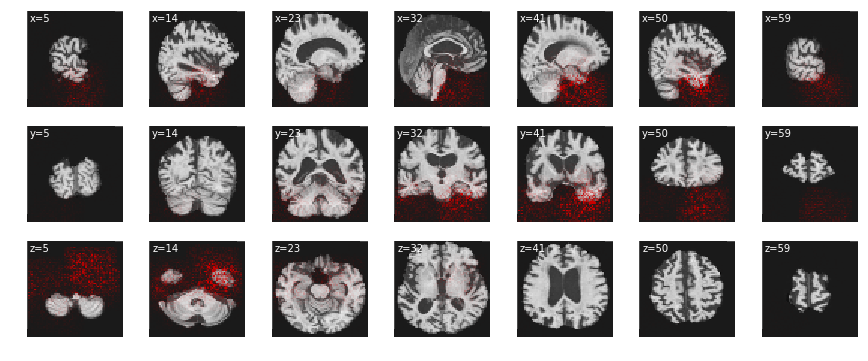

In [92]:
vis_utils.plot_slices(test_data[220][0], num_slices = 7, overlay=confounder_ex[0], 
                  overlay_vmax=np.percentile(confounder_ex, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [93]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                            conv_act='relu', fc_act='tanh').to(torch.device('cpu'))
net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])
net.eval()

regular_saliency = interpretation.sensitivity_analysis(net, test_data[220], cuda=False, verbose=True)

Image was classified as 1 with probability 0.9977214932441711
one hot output:  tensor([[[0.],
         [1.]]])


tensor(-1.1191) tensor(2.6709) 3.907985e-13 4.064317332086e-05


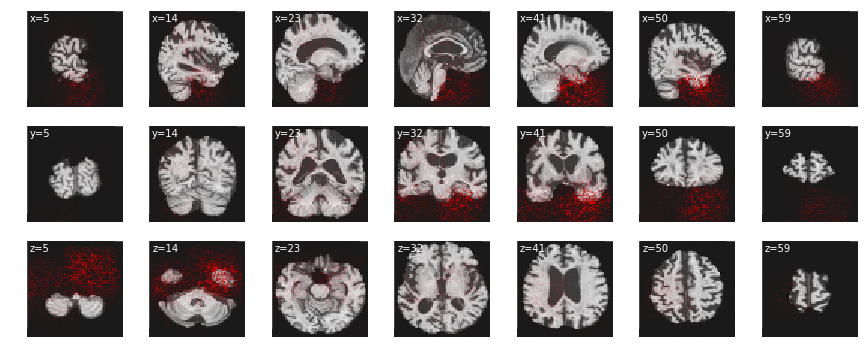

In [94]:
vis_utils.plot_slices(test_data[220][0], num_slices = 7, overlay=regular_saliency[0], 
                  overlay_vmax=np.percentile(regular_saliency, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)